In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from dataclasses import dataclass, field
from typing import Optional, List
import os


In [110]:
current_directory = os.getcwd()

# Print the current working directory
print(f"Current working directory: {current_directory}")

Current working directory: c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\01_intro\homework


In [112]:
@dataclass
class DataLoader(object):
    folder_name: str
    filename: str
    final_path: Optional[str] = field(init=False, repr=False)

    def __post_init__(self):
        self.final_path = os.path.join(self.folder_name, self.filename)
    
    def load_data(self) -> None:
        if self.filename.endswith(".csv"):
            dataframe_loaded = pd.read_csv(self.final_path)
            lowercase = lambda x: str(x).lower()
            dataframe_loaded.rename(lowercase, axis='columns', inplace=True)
            
            # Convert the time columns to the appropriate datetime format.
            dataframe_loaded['tpep_pickup_datetime'] = pd.to_datetime(dataframe_loaded['tpep_pickup_datetime'])
            dataframe_loaded['tpep_dropoff_datetime'] = pd.to_datetime(dataframe_loaded['tpep_dropoff_datetime'])
            print(f"The original dataframe has this number of columns: {dataframe_loaded.shape[1]} and rows: {dataframe_loaded.shape[0]}")
            
        elif self.filename.endswith(".parquet"):
            dataframe_loaded = pd.read_parquet(self.final_path)
            lowercase = lambda x: str(x).lower()
            dataframe_loaded.rename(lowercase, axis='columns', inplace=True)
            print(f"The original dataframe has this number of columns: {dataframe_loaded.shape[1]} and rows: {dataframe_loaded.shape[0]}")
            
        dataframe_loaded['trip_duration'] =  ((dataframe_loaded['tpep_dropoff_datetime'] - dataframe_loaded['tpep_pickup_datetime']).dt.total_seconds()) / 60  
        
            
        return dataframe_loaded
    
    def data_cleaning_manipulation(self, dataframe_loaded, durationcolumn: str, min_duration: int, max_duration: int):
        standard_deviation_calc = np.std(dataframe_loaded[durationcolumn])
        print(f"The standard deviation of the calculated trip duration is: {standard_deviation_calc}")
        
        # Plot the histogram of the trip duration
        sns.histplot(dataframe_loaded[durationcolumn])
        plt.xlabel('Trip Duration (minutes)')
        plt.ylabel('Frequency')
        plt.title('Trip Duration Distribution')
        plt.show()
        
        # Filter the DataFrame based on the trip duration range
        dataframe_cleaned = dataframe_loaded[(dataframe_loaded[durationcolumn] >= min_duration) & (dataframe_loaded[durationcolumn] <= max_duration)]
        print(f"Filtered dataframe has this number of columns: {dataframe_cleaned.shape[1]} and rows: {dataframe_cleaned.shape[0]}")
        
        percentage_remaining = (dataframe_cleaned.shape[0] / dataframe_loaded.shape[0]) * 100
        print(f"Percentage of data remaining after filtering: {percentage_remaining:.2f}%")
        
        return dataframe_cleaned     

In [120]:
@dataclass
class ModelTraining:
    categorical: List[str]
    numerical: List[str]
    target_column: str
    training_data: pd.DataFrame = field(default_factory=pd.DataFrame)
    validation_data: pd.DataFrame = field(default_factory=pd.DataFrame)
    
    
    def one_hot_encoder_training(self):
        self.training_data[self.categorical] = self.training_data[self.categorical].astype(str)
        print(self.training_data[self.categorical].dtypes)
        train_dicts = self.training_data[self.categorical + self.numerical].to_dict(orient = "records")
        #* Target training
        y_train = self.training_data[self.target_column].values
        
        
        # Applying a one hot encoder to the categorical variables.
        dv = DictVectorizer()
        X_train = dv.fit_transform(train_dicts)
        # Calculate the dimensionality of the feature matrix
        num_features = X_train.shape[1]
        print(f"Dimensionality of the feature matrix: {num_features} columns")
        
        self.dv = dv
        return X_train, y_train
    
    
    def one_hot_encoder_validation(self):
        self.validation_data[self.categorical] = self.validation_data[self.categorical].astype(str)
        print(self.validation_data[self.categorical].dtypes)
        val_dicts = self.validation_data[self.categorical + self.numerical].to_dict(orient = "records")
        #* Target training
        y_val = self.validation_data[self.target_column].values
        
        # Applying a one hot encoder to the categorical variables.
        X_val = self.dv.transform(val_dicts)
        # Calculate the dimensionality of the feature matrix
        num_features = X_val.shape[1]
        print(f"Dimensionality of the feature matrix: {num_features} columns")
        
        return X_val, y_val
    
    
    def model_train(self, X_train, y_train, X_val, y_val):
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        
        y_pred = lr.predict(X_train)
        mse_calculated = mean_squared_error(y_train, y_pred, squared=False)
        print(f"The Mean Squared Error is: {mse_calculated}")
        
        # Plot the Precition
        sns.histplot(y_pred, label='Prediction')
        sns.histplot(y_train, label="Actual")
        plt.legend()
        
        y_pred_val = lr.predict(X_val)
        mse_calculated_val = mean_squared_error(y_val, y_pred_val, squared=False)
        print(f"The Mean Squared Error Validation is: {mse_calculated_val}")

### Data Loading January

In [115]:
data_loader_january = DataLoader(folder_name="..\\data", 
                                 filename='yellow_tripdata_2023-01.parquet')
yellow_data_january = data_loader_january.load_data()
yellow_data_january.head()

The original dataframe has this number of columns: 19 and rows: 3066766


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


The standard deviation of the calculated trip duration is: 42.59434429744777


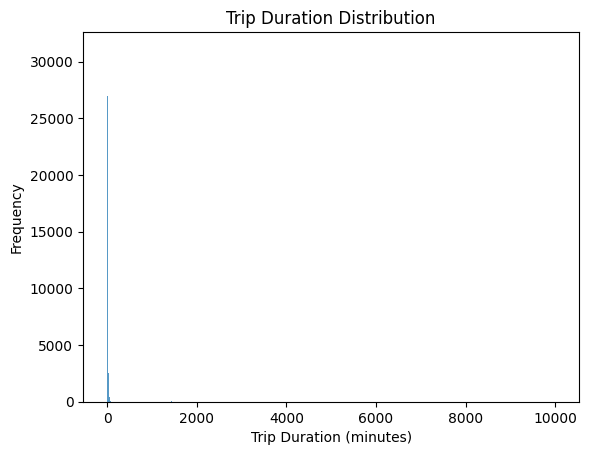

Filtered dataframe has this number of columns: 20 and rows: 3009173
Percentage of data remaining after filtering: 98.12%


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


In [116]:
yellow_data_january_cleaned = data_loader_january.data_cleaning_manipulation(dataframe_loaded=yellow_data_january, 
                                                                             durationcolumn="trip_duration", 
                                                                             min_duration=1, max_duration=60)
yellow_data_january_cleaned.head()

### Data Loaded February:

In [117]:
data_loader_february = DataLoader(folder_name="..\\data", 
                                  filename='yellow_tripdata_2023-02.parquet')
yellow_data_february = data_loader_february.load_data()
yellow_data_february.head()

The original dataframe has this number of columns: 19 and rows: 2913955


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.0,0.30,1.0,N,142,163,2,4.4,3.50,0.5,0.0,0.0,1.0,9.40,2.5,0.00,1.683333
1,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,-3.0,-1.00,-0.5,0.0,0.0,-1.0,-5.50,0.0,0.00,0.233333
2,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,3.0,1.00,0.5,0.0,0.0,1.0,5.50,0.0,0.00,0.233333
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.0,18.80,1.0,N,132,26,1,70.9,2.25,0.5,0.0,0.0,1.0,74.65,0.0,1.25,32.083333
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.0,3.22,1.0,N,161,145,1,17.0,1.00,0.5,3.3,0.0,1.0,25.30,2.5,0.00,13.300000


The standard deviation of the calculated trip duration is: 42.84209440985569


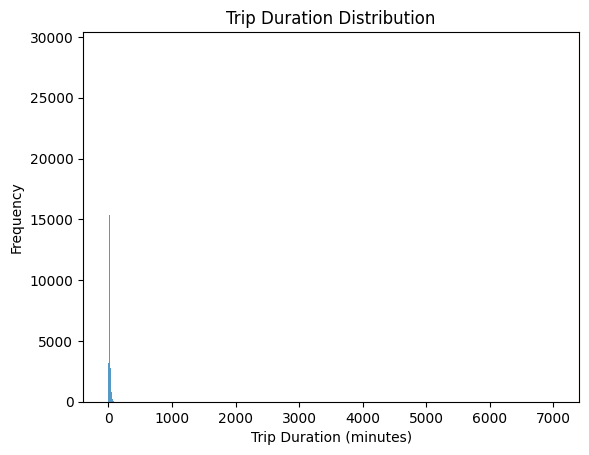

Filtered dataframe has this number of columns: 20 and rows: 2855951
Percentage of data remaining after filtering: 98.01%


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.0,0.30,1.0,N,142,163,2,4.4,3.50,0.5,0.00,0.0,1.0,9.40,2.5,0.00,1.683333
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.0,18.80,1.0,N,132,26,1,70.9,2.25,0.5,0.00,0.0,1.0,74.65,0.0,1.25,32.083333
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.0,3.22,1.0,N,161,145,1,17.0,1.00,0.5,3.30,0.0,1.0,25.30,2.5,0.00,13.300000
5,1,2023-02-01 00:52:40,2023-02-01 01:07:18,1.0,5.10,1.0,N,148,236,1,21.9,3.50,0.5,5.35,0.0,1.0,32.25,2.5,0.00,14.633333
6,1,2023-02-01 00:12:39,2023-02-01 00:40:36,1.0,8.90,1.0,N,137,244,1,41.5,3.50,0.5,3.50,0.0,1.0,50.00,2.5,0.00,27.950000


In [118]:
yellow_data_february_cleaned = data_loader_february.data_cleaning_manipulation(dataframe_loaded=yellow_data_february, 
                                                                               durationcolumn="trip_duration", 
                                                                               min_duration=1, 
                                                                               max_duration=60)
yellow_data_february_cleaned.head()

### Model Training

C:\Users\CamiloA\AppData\Local\Temp\ipykernel_4764\3413754178.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.training_data[self.categorical] = self.training_data[self.categorical].astype(str)


pulocationid    object
dolocationid    object
dtype: object
Dimensionality of the feature matrix: 516 columns


C:\Users\CamiloA\AppData\Local\Temp\ipykernel_4764\3413754178.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.validation_data[self.categorical] = self.validation_data[self.categorical].astype(str)


pulocationid    object
dolocationid    object
dtype: object
Dimensionality of the feature matrix: 516 columns


c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The Mean Squared Error is: 7.658559076531841


c:\Users\CamiloA\OneDrive\Documents\Python Scripts\mlops_2024\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The Mean Squared Error Validation is: 7.820057137415617


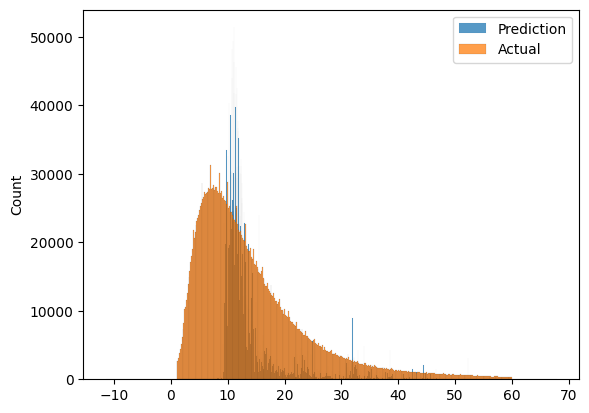

In [121]:
model_train = ModelTraining(categorical=['pulocationid', 'dolocationid'],
                            numerical=['trip_distance'],
                            target_column="trip_duration",
                            training_data=yellow_data_january_cleaned,
                            validation_data=yellow_data_february_cleaned)

X_train, y_train = model_train.one_hot_encoder_training()
X_val, y_val = model_train.one_hot_encoder_validation()

model_train.model_train(X_train=X_train,
                        y_train=y_train,
                        X_val=X_val,
                        y_val=y_val)